#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


## Lab. 05 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

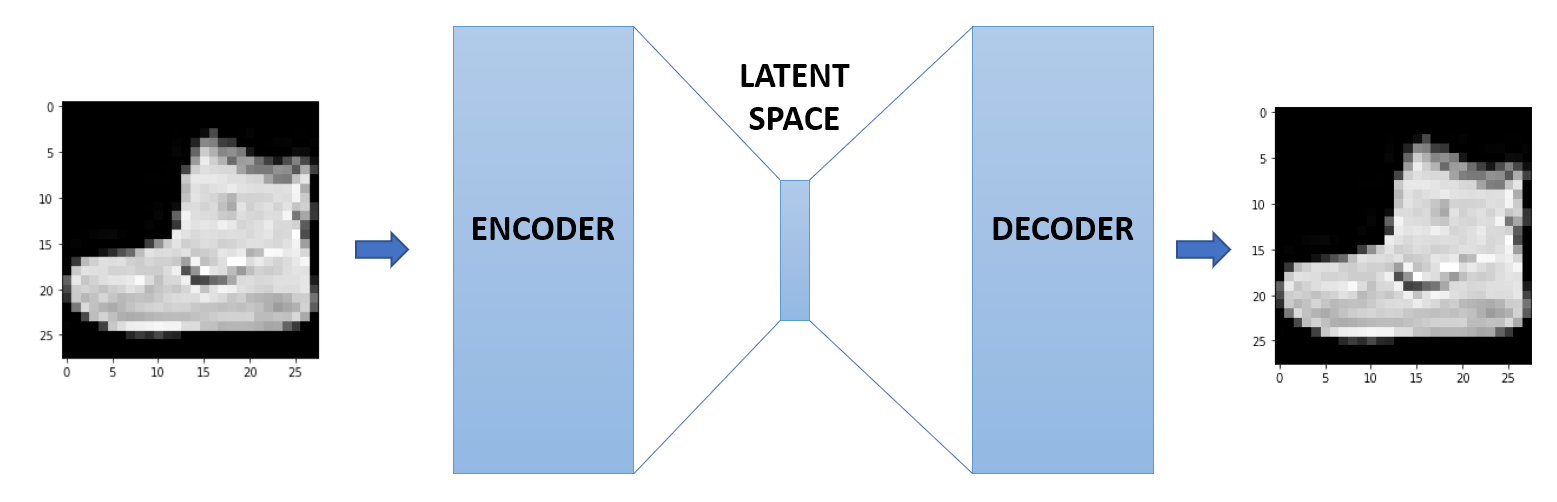

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be **unsupervised** since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
# !pip install numpy
# !pip pip3 install torch torchvision torchaudio
# !pip install tqdm
# !pip install matplotlib
# !pip install scikit-image
# !pip install scipy
# !pip install scikit-learn
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install tensorboard
 

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)).

**NOTE:** These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The Fashion MNIST dataset is a colletion of Zalando's article images. The size of the images is $28 \times 28$, and there is a single channel only (black and white images) with 10 classes.

In [3]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

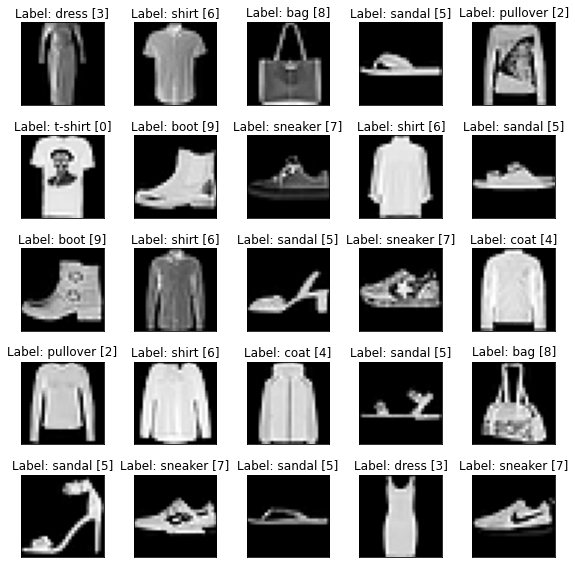

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [5]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [6]:
# check what is going on BEFORE the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(<PIL.Image.Image image mode=L size=28x28 at 0x7F984DD99E90>, 9)
<PIL.Image.Image image mode=L size=28x28 at 0x7F984DD99DD0>
9


In [7]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [8]:
# check what is going on AFTER the transformation is in place!
print(train_dataset)
print(train_dataset[0])
print(train_dataset[0][0])
print(train_dataset[0][1])

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [9]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

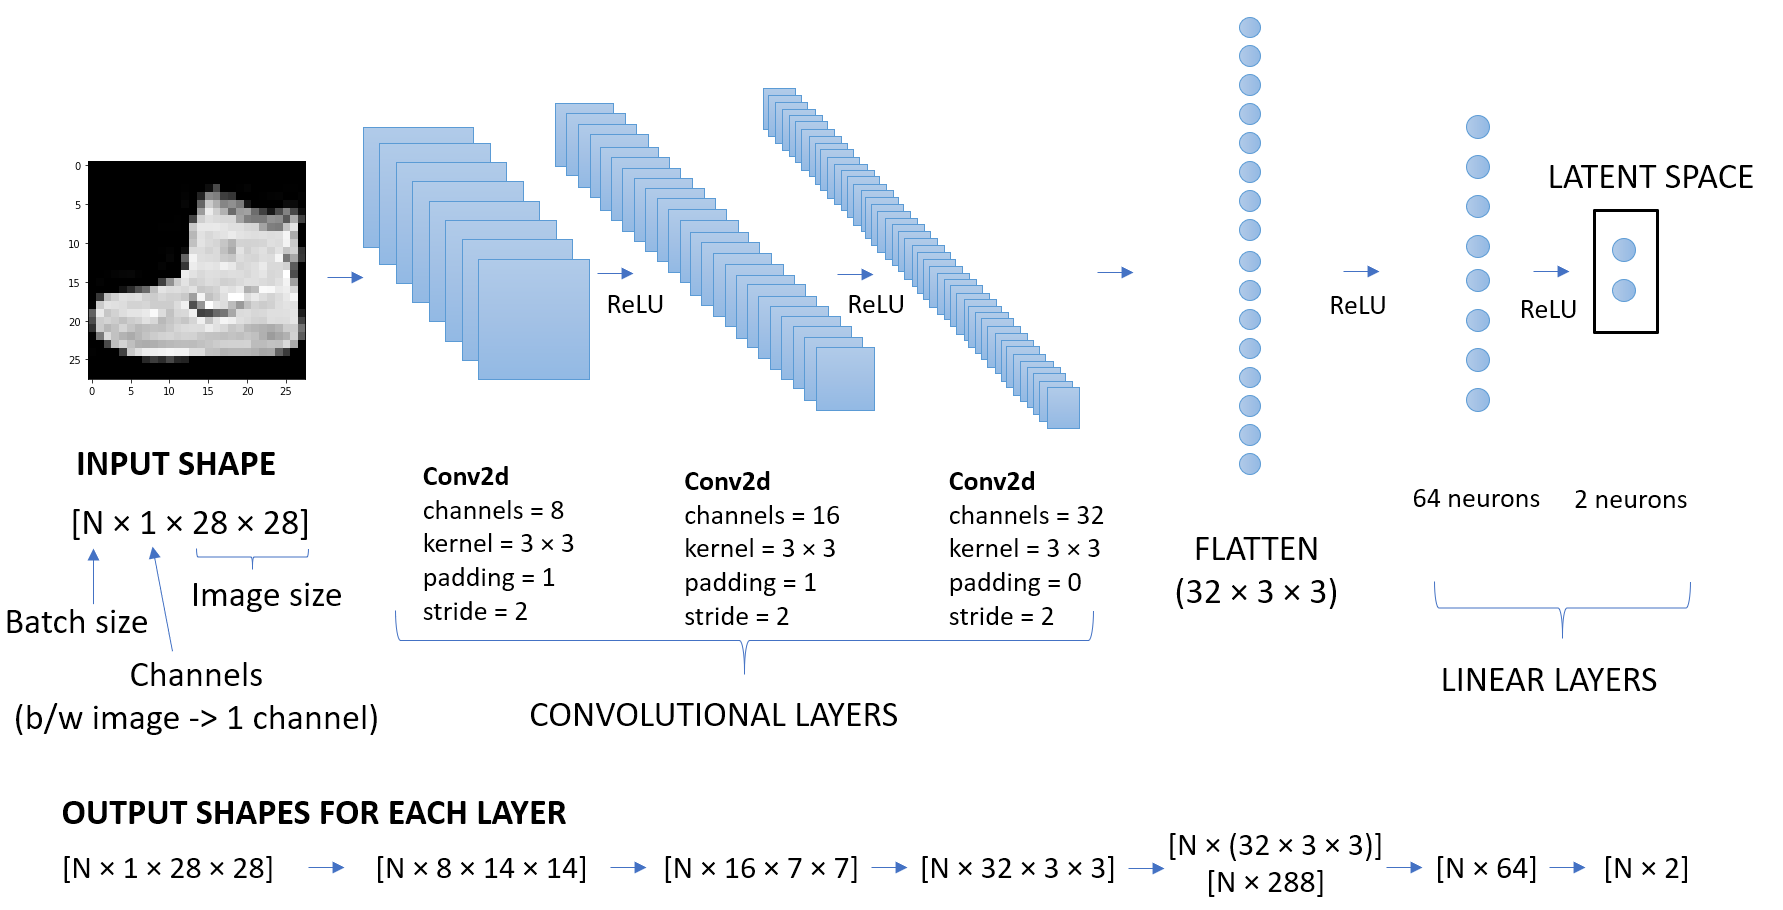

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [10]:
# TODO: fill the holes with the number from the above figure.

class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels= 1, out_channels=8, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, 
                      stride=2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, 
                      stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer

            nn.Linear(in_features=32*3*3, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=2)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successful implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

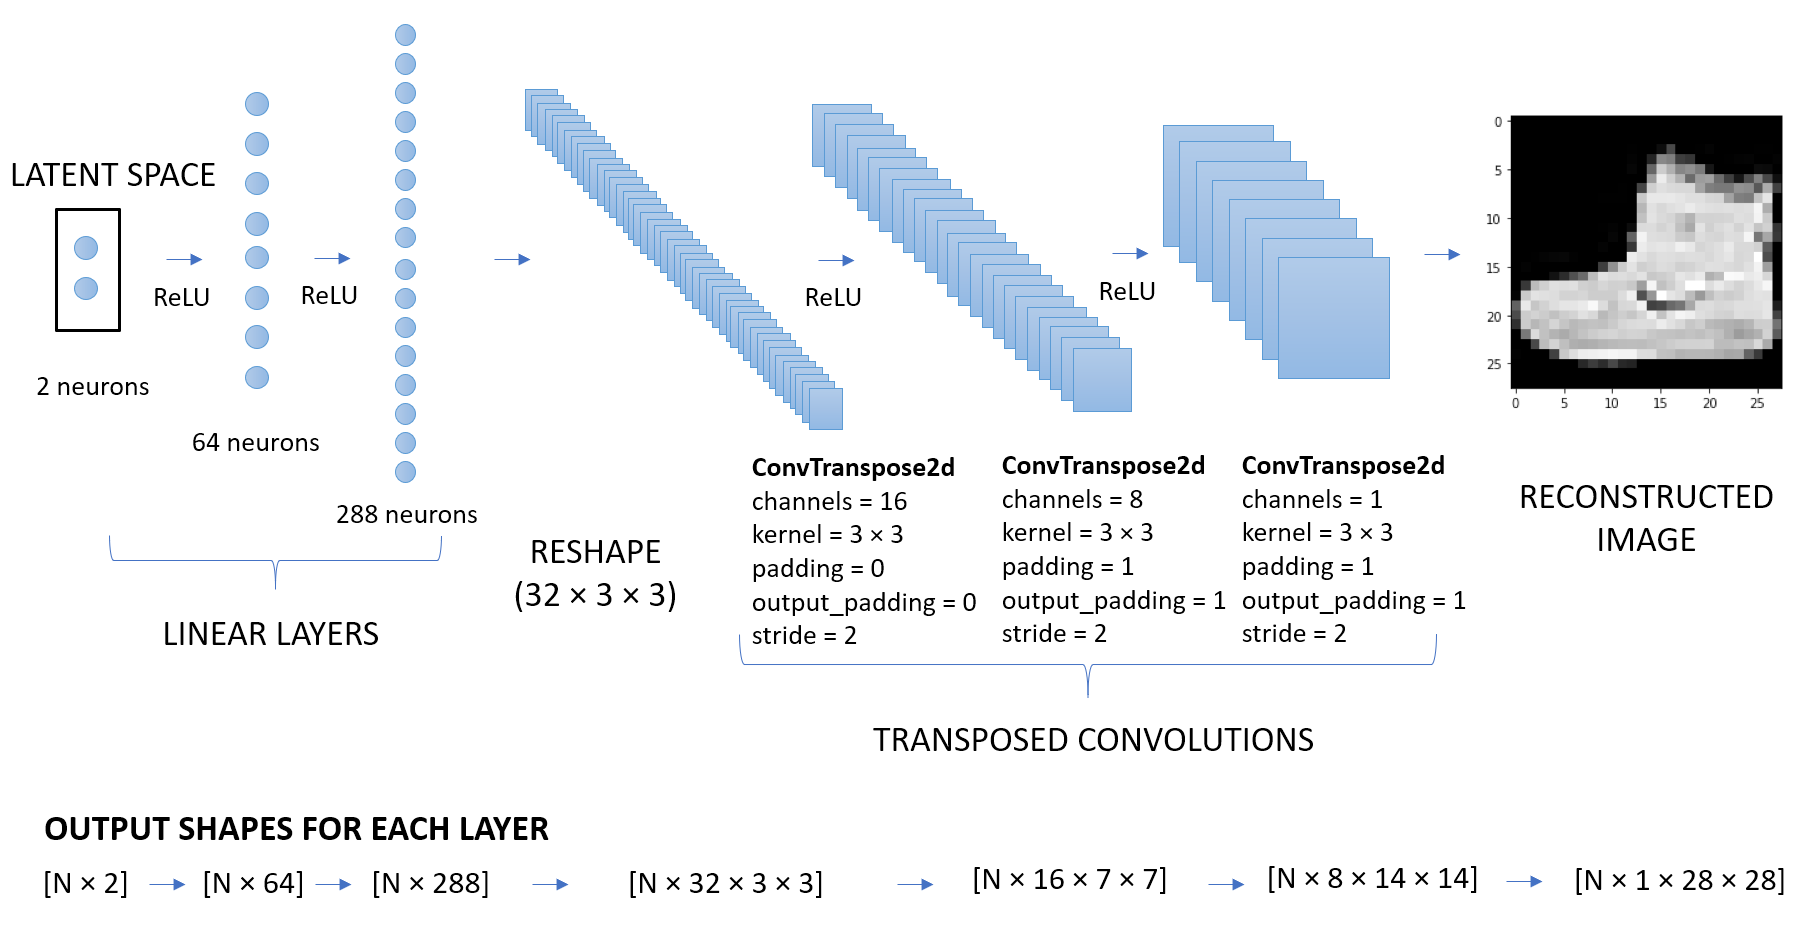

In [11]:
# TODO: fill the holes with the number from the above figure.

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=2, out_features=64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, 
                               stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, 
                               stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, 
                               stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [12]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [13]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axisfig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the training loop.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [14]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [15]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [16]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10
	 partial train loss (single batch): 0.179494
	 partial train loss (single batch): 0.181603
	 partial train loss (single batch): 0.180025
	 partial train loss (single batch): 0.178158
	 partial train loss (single batch): 0.182383
	 partial train loss (single batch): 0.177239
	 partial train loss (single batch): 0.178596
	 partial train loss (single batch): 0.177731
	 partial train loss (single batch): 0.178102
	 partial train loss (single batch): 0.174652
	 partial train loss (single batch): 0.179585
	 partial train loss (single batch): 0.180975
	 partial train loss (single batch): 0.173913
	 partial train loss (single batch): 0.174123
	 partial train loss (single batch): 0.174520
	 partial train loss (single batch): 0.175449
	 partial train loss (single batch): 0.178706
	 partial train loss (single batch): 0.176363
	 partial train loss (single batch): 0.176311
	 partial train loss (single batch): 0.179125
	 partial train loss (single batch): 0.175773
	 partial train loss (s

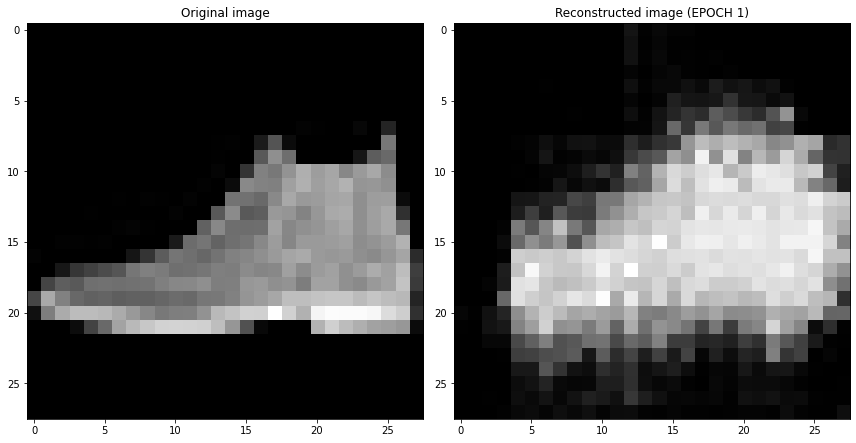

EPOCH 2/10
	 partial train loss (single batch): 0.063207
	 partial train loss (single batch): 0.061257
	 partial train loss (single batch): 0.062993
	 partial train loss (single batch): 0.057867
	 partial train loss (single batch): 0.061718
	 partial train loss (single batch): 0.059883
	 partial train loss (single batch): 0.059976
	 partial train loss (single batch): 0.059137
	 partial train loss (single batch): 0.058087
	 partial train loss (single batch): 0.059286
	 partial train loss (single batch): 0.059377
	 partial train loss (single batch): 0.057168
	 partial train loss (single batch): 0.060880
	 partial train loss (single batch): 0.058610
	 partial train loss (single batch): 0.058171
	 partial train loss (single batch): 0.061140
	 partial train loss (single batch): 0.059123
	 partial train loss (single batch): 0.058350
	 partial train loss (single batch): 0.056559
	 partial train loss (single batch): 0.059424
	 partial train loss (single batch): 0.058335
	 partial train loss (s

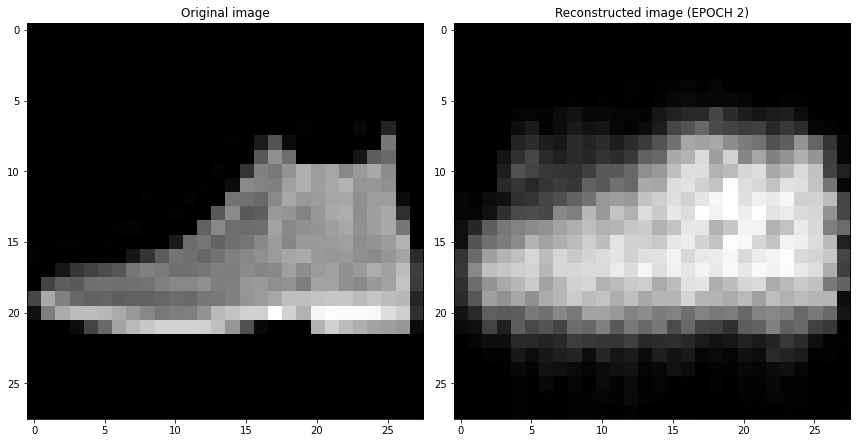

EPOCH 3/10
	 partial train loss (single batch): 0.042121
	 partial train loss (single batch): 0.042101
	 partial train loss (single batch): 0.042337
	 partial train loss (single batch): 0.043094
	 partial train loss (single batch): 0.041932
	 partial train loss (single batch): 0.040464
	 partial train loss (single batch): 0.044707
	 partial train loss (single batch): 0.042507
	 partial train loss (single batch): 0.043162
	 partial train loss (single batch): 0.039740
	 partial train loss (single batch): 0.042809
	 partial train loss (single batch): 0.042992
	 partial train loss (single batch): 0.040881
	 partial train loss (single batch): 0.043380
	 partial train loss (single batch): 0.043195
	 partial train loss (single batch): 0.043150
	 partial train loss (single batch): 0.040834
	 partial train loss (single batch): 0.042130
	 partial train loss (single batch): 0.040633
	 partial train loss (single batch): 0.042556
	 partial train loss (single batch): 0.041144
	 partial train loss (s

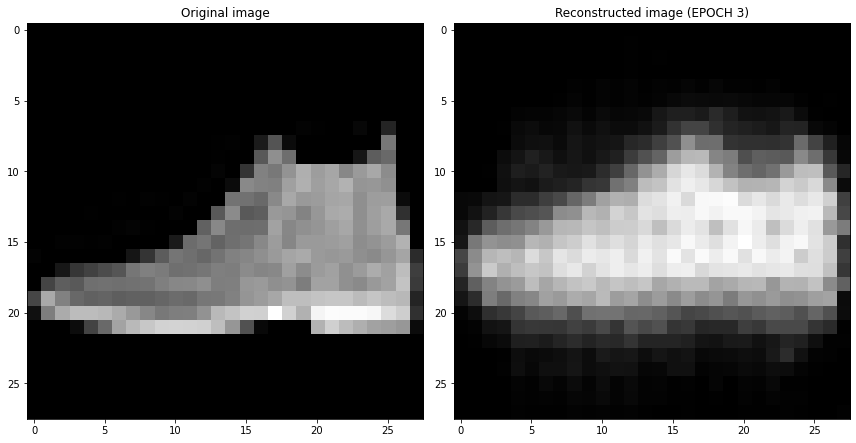

EPOCH 4/10
	 partial train loss (single batch): 0.039448
	 partial train loss (single batch): 0.039141
	 partial train loss (single batch): 0.039843
	 partial train loss (single batch): 0.038259
	 partial train loss (single batch): 0.038813
	 partial train loss (single batch): 0.038225
	 partial train loss (single batch): 0.037958
	 partial train loss (single batch): 0.040978
	 partial train loss (single batch): 0.038800
	 partial train loss (single batch): 0.036374
	 partial train loss (single batch): 0.040806
	 partial train loss (single batch): 0.037763
	 partial train loss (single batch): 0.036239
	 partial train loss (single batch): 0.041403
	 partial train loss (single batch): 0.039510
	 partial train loss (single batch): 0.040454
	 partial train loss (single batch): 0.039120
	 partial train loss (single batch): 0.039726
	 partial train loss (single batch): 0.037802
	 partial train loss (single batch): 0.040271
	 partial train loss (single batch): 0.036588
	 partial train loss (s

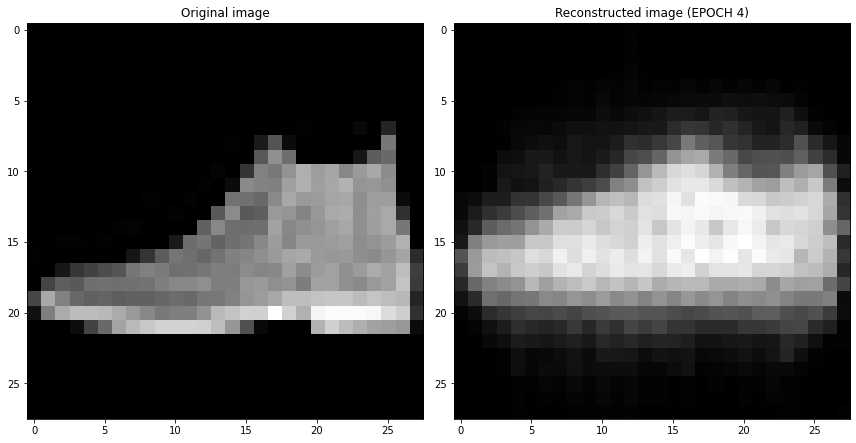

EPOCH 5/10
	 partial train loss (single batch): 0.036365
	 partial train loss (single batch): 0.037450
	 partial train loss (single batch): 0.035935
	 partial train loss (single batch): 0.037219
	 partial train loss (single batch): 0.039044
	 partial train loss (single batch): 0.037697
	 partial train loss (single batch): 0.036384
	 partial train loss (single batch): 0.037886
	 partial train loss (single batch): 0.038694
	 partial train loss (single batch): 0.037140
	 partial train loss (single batch): 0.039505
	 partial train loss (single batch): 0.038630
	 partial train loss (single batch): 0.036387
	 partial train loss (single batch): 0.035205
	 partial train loss (single batch): 0.035865
	 partial train loss (single batch): 0.038817
	 partial train loss (single batch): 0.036312
	 partial train loss (single batch): 0.038029
	 partial train loss (single batch): 0.041810
	 partial train loss (single batch): 0.038637
	 partial train loss (single batch): 0.036697
	 partial train loss (s

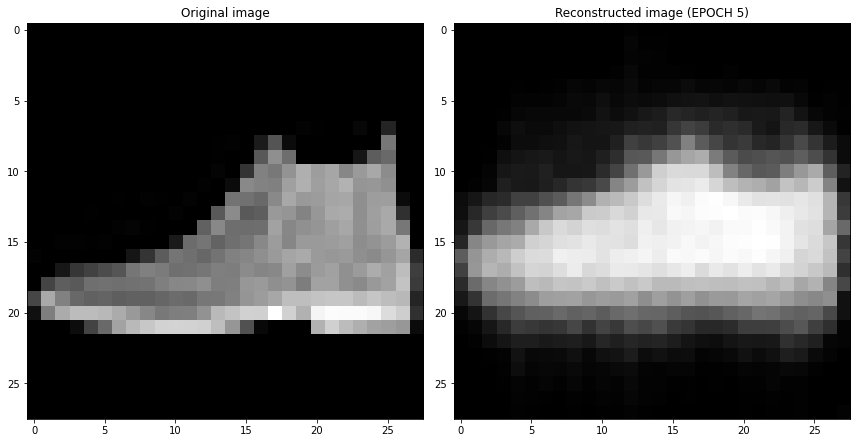

EPOCH 6/10
	 partial train loss (single batch): 0.033657
	 partial train loss (single batch): 0.034211
	 partial train loss (single batch): 0.036925
	 partial train loss (single batch): 0.033991
	 partial train loss (single batch): 0.035543
	 partial train loss (single batch): 0.034916
	 partial train loss (single batch): 0.035294
	 partial train loss (single batch): 0.034152
	 partial train loss (single batch): 0.034585
	 partial train loss (single batch): 0.035551
	 partial train loss (single batch): 0.033053
	 partial train loss (single batch): 0.036186
	 partial train loss (single batch): 0.036969
	 partial train loss (single batch): 0.036635
	 partial train loss (single batch): 0.032328
	 partial train loss (single batch): 0.034353
	 partial train loss (single batch): 0.035490
	 partial train loss (single batch): 0.034118
	 partial train loss (single batch): 0.033561
	 partial train loss (single batch): 0.035061
	 partial train loss (single batch): 0.033043
	 partial train loss (s

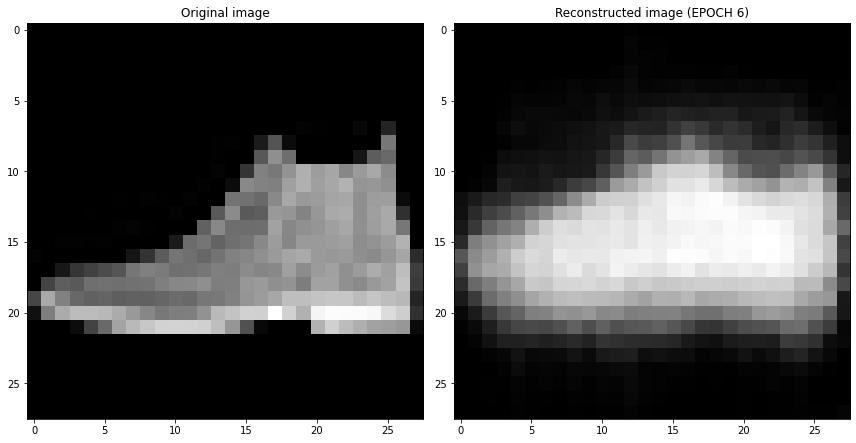

EPOCH 7/10
	 partial train loss (single batch): 0.035170
	 partial train loss (single batch): 0.033023
	 partial train loss (single batch): 0.033735
	 partial train loss (single batch): 0.033632
	 partial train loss (single batch): 0.034853
	 partial train loss (single batch): 0.033086
	 partial train loss (single batch): 0.033350
	 partial train loss (single batch): 0.030919
	 partial train loss (single batch): 0.034721
	 partial train loss (single batch): 0.032301
	 partial train loss (single batch): 0.033897
	 partial train loss (single batch): 0.035638
	 partial train loss (single batch): 0.033377
	 partial train loss (single batch): 0.032267
	 partial train loss (single batch): 0.034414
	 partial train loss (single batch): 0.035255
	 partial train loss (single batch): 0.034558
	 partial train loss (single batch): 0.033556
	 partial train loss (single batch): 0.033215
	 partial train loss (single batch): 0.034509
	 partial train loss (single batch): 0.035230
	 partial train loss (s

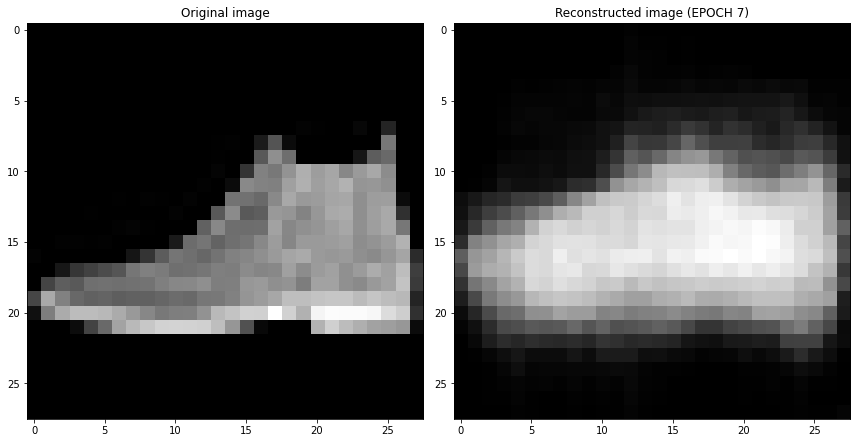

EPOCH 8/10
	 partial train loss (single batch): 0.033725
	 partial train loss (single batch): 0.034078
	 partial train loss (single batch): 0.033920
	 partial train loss (single batch): 0.033017
	 partial train loss (single batch): 0.034207
	 partial train loss (single batch): 0.033471
	 partial train loss (single batch): 0.034627
	 partial train loss (single batch): 0.034655
	 partial train loss (single batch): 0.033406
	 partial train loss (single batch): 0.033554
	 partial train loss (single batch): 0.033704
	 partial train loss (single batch): 0.033420
	 partial train loss (single batch): 0.033297
	 partial train loss (single batch): 0.031965
	 partial train loss (single batch): 0.034006
	 partial train loss (single batch): 0.035109
	 partial train loss (single batch): 0.034887
	 partial train loss (single batch): 0.034612
	 partial train loss (single batch): 0.035311
	 partial train loss (single batch): 0.032161
	 partial train loss (single batch): 0.035843
	 partial train loss (s

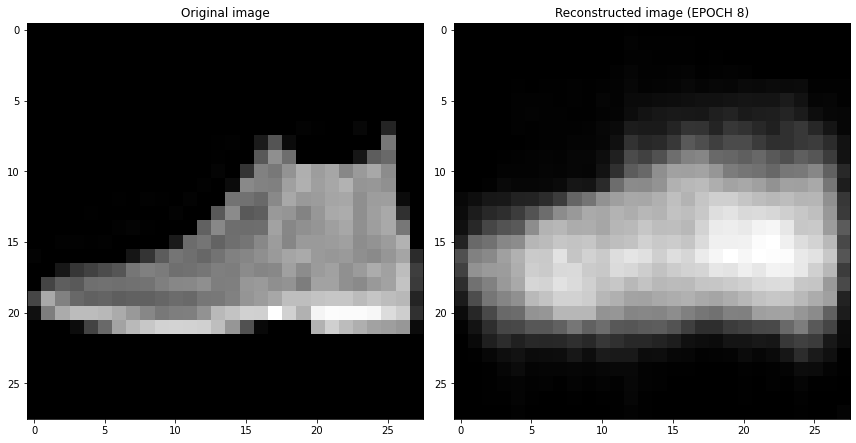

EPOCH 9/10
	 partial train loss (single batch): 0.033405
	 partial train loss (single batch): 0.032605
	 partial train loss (single batch): 0.033734
	 partial train loss (single batch): 0.031516
	 partial train loss (single batch): 0.032089
	 partial train loss (single batch): 0.032369
	 partial train loss (single batch): 0.033597
	 partial train loss (single batch): 0.036273
	 partial train loss (single batch): 0.031769
	 partial train loss (single batch): 0.032582
	 partial train loss (single batch): 0.033434
	 partial train loss (single batch): 0.031651
	 partial train loss (single batch): 0.031669
	 partial train loss (single batch): 0.033475
	 partial train loss (single batch): 0.035831
	 partial train loss (single batch): 0.030821
	 partial train loss (single batch): 0.033797
	 partial train loss (single batch): 0.032924
	 partial train loss (single batch): 0.034564
	 partial train loss (single batch): 0.032219
	 partial train loss (single batch): 0.033954
	 partial train loss (s

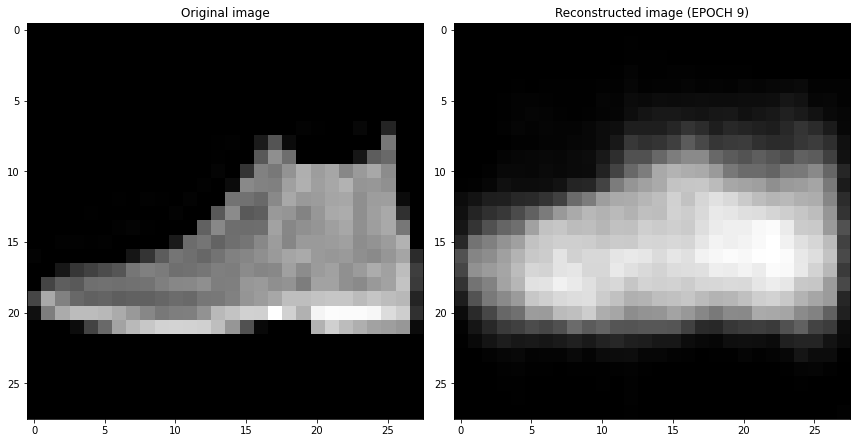

EPOCH 10/10
	 partial train loss (single batch): 0.032638
	 partial train loss (single batch): 0.031410
	 partial train loss (single batch): 0.032389
	 partial train loss (single batch): 0.030991
	 partial train loss (single batch): 0.033298
	 partial train loss (single batch): 0.035064
	 partial train loss (single batch): 0.033945
	 partial train loss (single batch): 0.033037
	 partial train loss (single batch): 0.034378
	 partial train loss (single batch): 0.032858
	 partial train loss (single batch): 0.033371
	 partial train loss (single batch): 0.032709
	 partial train loss (single batch): 0.031532
	 partial train loss (single batch): 0.031800
	 partial train loss (single batch): 0.031894
	 partial train loss (single batch): 0.032191
	 partial train loss (single batch): 0.033672
	 partial train loss (single batch): 0.032187
	 partial train loss (single batch): 0.032376
	 partial train loss (single batch): 0.032513
	 partial train loss (single batch): 0.031632
	 partial train loss (

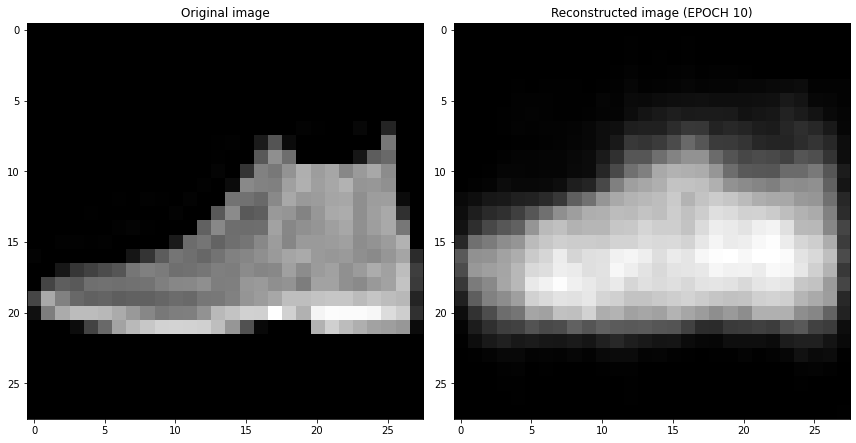

In [17]:

### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')


    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [18]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [19]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:08<00:00, 1249.23it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [20]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-4.693071,-17.296408,9
1,1.524937,11.827147,2
2,-39.970810,9.642570,1
3,-43.991482,5.900041,1
4,-5.046025,-1.796400,6
...,...,...,...
9995,14.150975,-15.659468,9
9996,-35.796787,-0.011497,1
9997,-11.834634,-0.770186,8
9998,-51.133133,8.059981,1


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [21]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the id of the class in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

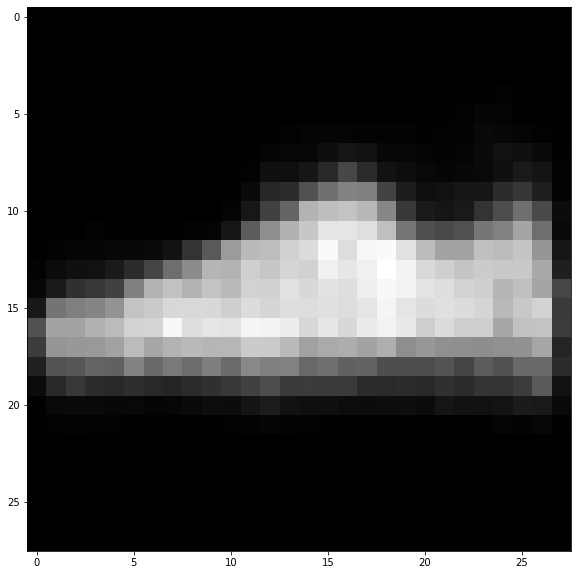

In [22]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [-6, -30.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

# Further insights on PCA and t-SNE

Let's do the same training again, with encoded dimension equal to 10.

Selected device: cuda
EPOCH 1/10
	 partial train loss (single batch): 0.179494
	 partial train loss (single batch): 0.181603
	 partial train loss (single batch): 0.180025
	 partial train loss (single batch): 0.178158
	 partial train loss (single batch): 0.182383
	 partial train loss (single batch): 0.177239
	 partial train loss (single batch): 0.178596
	 partial train loss (single batch): 0.177731
	 partial train loss (single batch): 0.178102
	 partial train loss (single batch): 0.174652
	 partial train loss (single batch): 0.179585
	 partial train loss (single batch): 0.180975
	 partial train loss (single batch): 0.173913
	 partial train loss (single batch): 0.174123
	 partial train loss (single batch): 0.174520
	 partial train loss (single batch): 0.175449
	 partial train loss (single batch): 0.178706
	 partial train loss (single batch): 0.176363
	 partial train loss (single batch): 0.176311
	 partial train loss (single batch): 0.179125
	 partial train loss (single batch): 0.175773
	

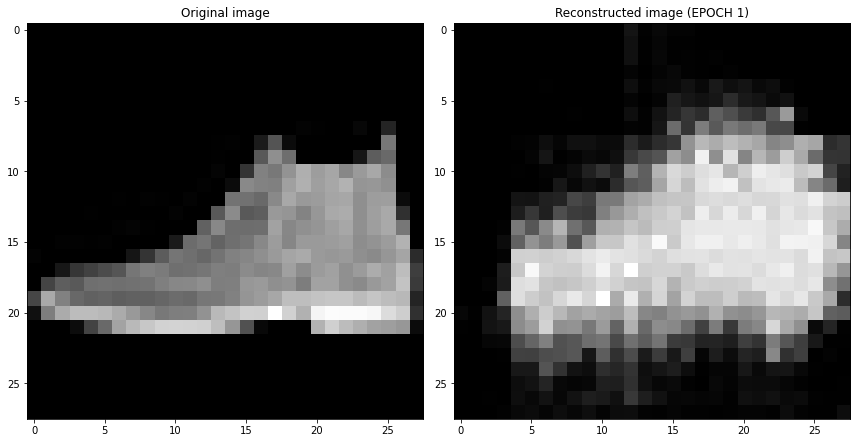

EPOCH 2/10
	 partial train loss (single batch): 0.063130
	 partial train loss (single batch): 0.061219
	 partial train loss (single batch): 0.062952
	 partial train loss (single batch): 0.057810
	 partial train loss (single batch): 0.061673
	 partial train loss (single batch): 0.059830
	 partial train loss (single batch): 0.059933
	 partial train loss (single batch): 0.059076
	 partial train loss (single batch): 0.058021
	 partial train loss (single batch): 0.059225
	 partial train loss (single batch): 0.059278
	 partial train loss (single batch): 0.057067
	 partial train loss (single batch): 0.060844
	 partial train loss (single batch): 0.058516
	 partial train loss (single batch): 0.058105
	 partial train loss (single batch): 0.061086
	 partial train loss (single batch): 0.059055
	 partial train loss (single batch): 0.058242
	 partial train loss (single batch): 0.056433
	 partial train loss (single batch): 0.059343
	 partial train loss (single batch): 0.058264
	 partial train loss (s

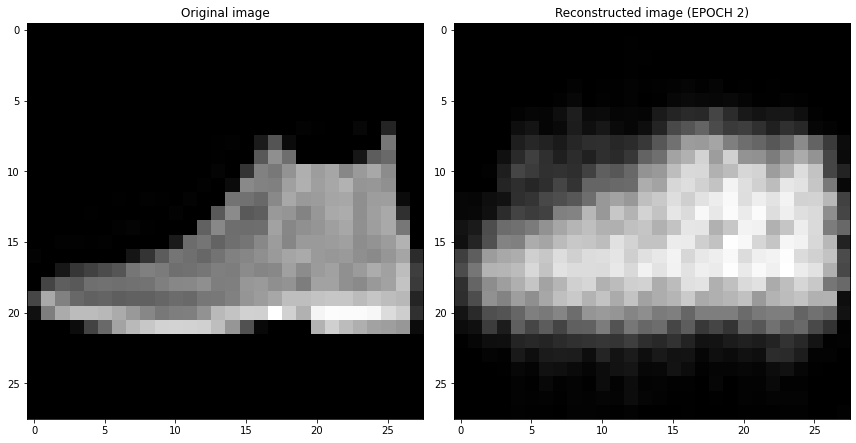

EPOCH 3/10
	 partial train loss (single batch): 0.042112
	 partial train loss (single batch): 0.042036
	 partial train loss (single batch): 0.042132
	 partial train loss (single batch): 0.042933
	 partial train loss (single batch): 0.041848
	 partial train loss (single batch): 0.040396
	 partial train loss (single batch): 0.044599
	 partial train loss (single batch): 0.042437
	 partial train loss (single batch): 0.043025
	 partial train loss (single batch): 0.039599
	 partial train loss (single batch): 0.042671
	 partial train loss (single batch): 0.042880
	 partial train loss (single batch): 0.040767
	 partial train loss (single batch): 0.043293
	 partial train loss (single batch): 0.043101
	 partial train loss (single batch): 0.043064
	 partial train loss (single batch): 0.040721
	 partial train loss (single batch): 0.042095
	 partial train loss (single batch): 0.040510
	 partial train loss (single batch): 0.042454
	 partial train loss (single batch): 0.041028
	 partial train loss (s

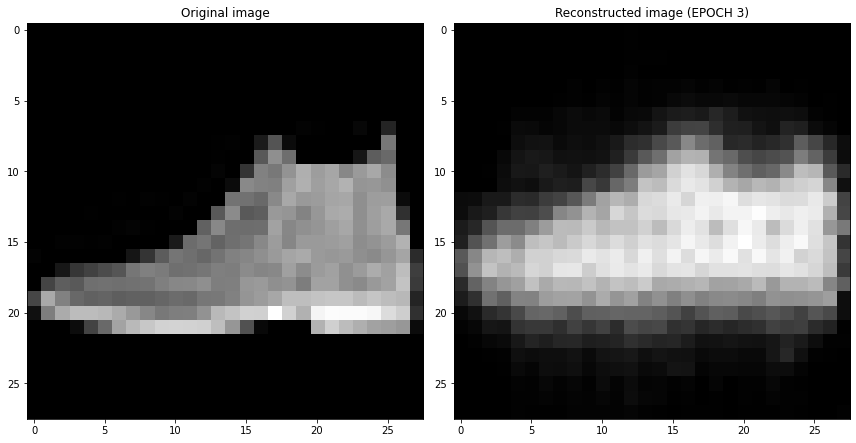

EPOCH 4/10
	 partial train loss (single batch): 0.039414
	 partial train loss (single batch): 0.039093
	 partial train loss (single batch): 0.039798
	 partial train loss (single batch): 0.038298
	 partial train loss (single batch): 0.038831
	 partial train loss (single batch): 0.038188
	 partial train loss (single batch): 0.038007
	 partial train loss (single batch): 0.040963
	 partial train loss (single batch): 0.038803
	 partial train loss (single batch): 0.036332
	 partial train loss (single batch): 0.040790
	 partial train loss (single batch): 0.037757
	 partial train loss (single batch): 0.036270
	 partial train loss (single batch): 0.041337
	 partial train loss (single batch): 0.039414
	 partial train loss (single batch): 0.040465
	 partial train loss (single batch): 0.039103
	 partial train loss (single batch): 0.039734
	 partial train loss (single batch): 0.037845
	 partial train loss (single batch): 0.040176
	 partial train loss (single batch): 0.036627
	 partial train loss (s

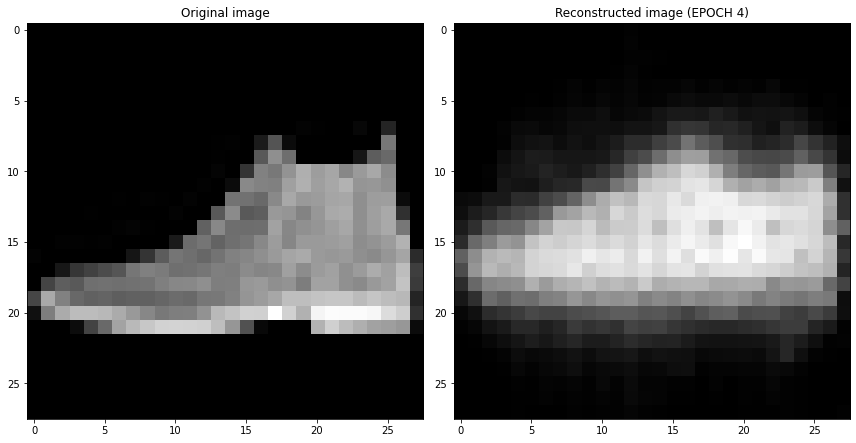

EPOCH 5/10
	 partial train loss (single batch): 0.036463
	 partial train loss (single batch): 0.037494
	 partial train loss (single batch): 0.036045
	 partial train loss (single batch): 0.037207
	 partial train loss (single batch): 0.038992
	 partial train loss (single batch): 0.037703
	 partial train loss (single batch): 0.036466
	 partial train loss (single batch): 0.037887
	 partial train loss (single batch): 0.038811
	 partial train loss (single batch): 0.037268
	 partial train loss (single batch): 0.039642
	 partial train loss (single batch): 0.038697
	 partial train loss (single batch): 0.036372
	 partial train loss (single batch): 0.035250
	 partial train loss (single batch): 0.035980
	 partial train loss (single batch): 0.038817
	 partial train loss (single batch): 0.036465
	 partial train loss (single batch): 0.038082
	 partial train loss (single batch): 0.041896
	 partial train loss (single batch): 0.038710
	 partial train loss (single batch): 0.036937
	 partial train loss (s

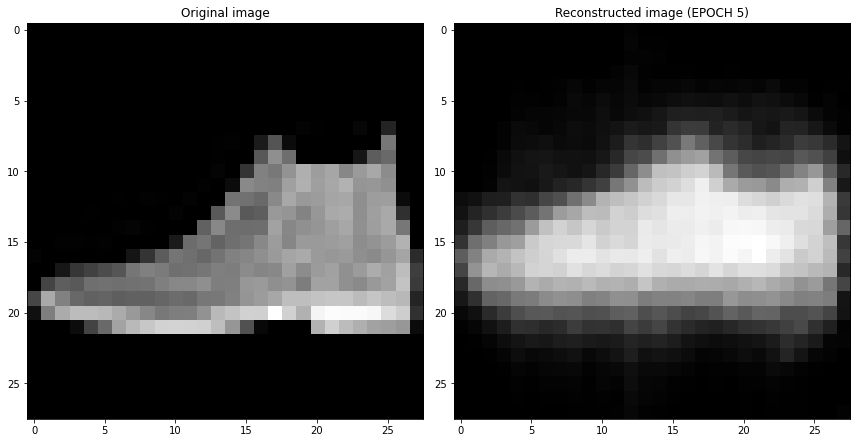

EPOCH 6/10
	 partial train loss (single batch): 0.033704
	 partial train loss (single batch): 0.034294
	 partial train loss (single batch): 0.037295
	 partial train loss (single batch): 0.034014
	 partial train loss (single batch): 0.035672
	 partial train loss (single batch): 0.035144
	 partial train loss (single batch): 0.035446
	 partial train loss (single batch): 0.034273
	 partial train loss (single batch): 0.034687
	 partial train loss (single batch): 0.035589
	 partial train loss (single batch): 0.033134
	 partial train loss (single batch): 0.036291
	 partial train loss (single batch): 0.037065
	 partial train loss (single batch): 0.036898
	 partial train loss (single batch): 0.032622
	 partial train loss (single batch): 0.034457
	 partial train loss (single batch): 0.035657
	 partial train loss (single batch): 0.034140
	 partial train loss (single batch): 0.033697
	 partial train loss (single batch): 0.035244
	 partial train loss (single batch): 0.033252
	 partial train loss (s

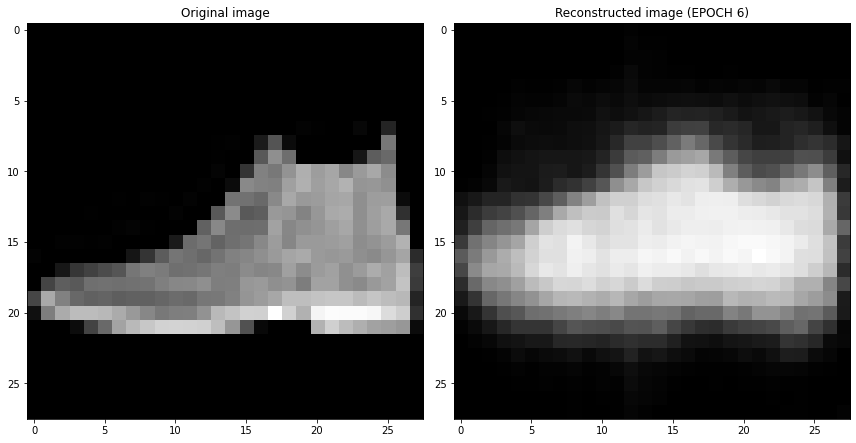

EPOCH 7/10
	 partial train loss (single batch): 0.035271
	 partial train loss (single batch): 0.033098
	 partial train loss (single batch): 0.033914
	 partial train loss (single batch): 0.033765
	 partial train loss (single batch): 0.034943
	 partial train loss (single batch): 0.033293
	 partial train loss (single batch): 0.033646
	 partial train loss (single batch): 0.030956
	 partial train loss (single batch): 0.034716
	 partial train loss (single batch): 0.032282
	 partial train loss (single batch): 0.033885
	 partial train loss (single batch): 0.035634
	 partial train loss (single batch): 0.033620
	 partial train loss (single batch): 0.032451
	 partial train loss (single batch): 0.034512
	 partial train loss (single batch): 0.035704
	 partial train loss (single batch): 0.034370
	 partial train loss (single batch): 0.033600
	 partial train loss (single batch): 0.033119
	 partial train loss (single batch): 0.034643
	 partial train loss (single batch): 0.035591
	 partial train loss (s

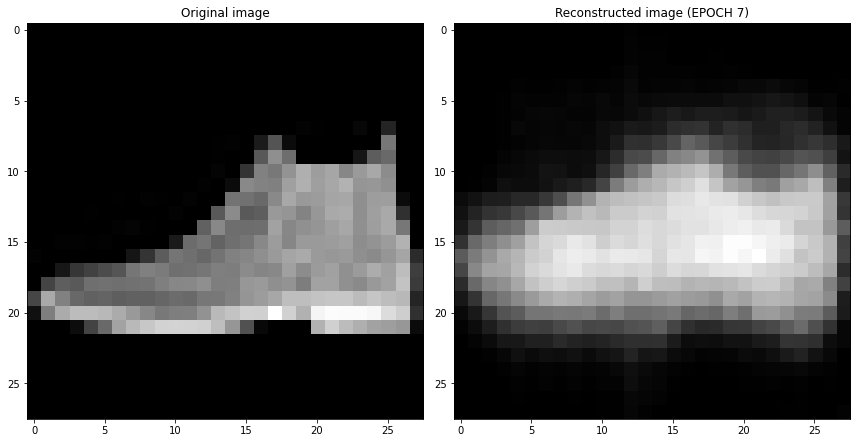

EPOCH 8/10
	 partial train loss (single batch): 0.033714
	 partial train loss (single batch): 0.034136
	 partial train loss (single batch): 0.033974
	 partial train loss (single batch): 0.032911
	 partial train loss (single batch): 0.034217
	 partial train loss (single batch): 0.033316
	 partial train loss (single batch): 0.034505
	 partial train loss (single batch): 0.034741
	 partial train loss (single batch): 0.033319
	 partial train loss (single batch): 0.033459
	 partial train loss (single batch): 0.033496
	 partial train loss (single batch): 0.033666
	 partial train loss (single batch): 0.033197
	 partial train loss (single batch): 0.031900
	 partial train loss (single batch): 0.033846
	 partial train loss (single batch): 0.035271
	 partial train loss (single batch): 0.034896
	 partial train loss (single batch): 0.034690
	 partial train loss (single batch): 0.034968
	 partial train loss (single batch): 0.032031
	 partial train loss (single batch): 0.035894
	 partial train loss (s

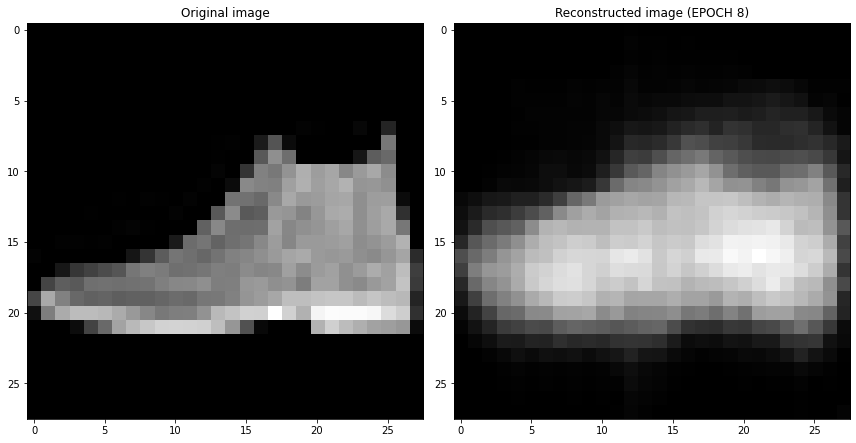

EPOCH 9/10
	 partial train loss (single batch): 0.033407
	 partial train loss (single batch): 0.032653
	 partial train loss (single batch): 0.033663
	 partial train loss (single batch): 0.031483
	 partial train loss (single batch): 0.032240
	 partial train loss (single batch): 0.032343
	 partial train loss (single batch): 0.033662
	 partial train loss (single batch): 0.035835
	 partial train loss (single batch): 0.031586
	 partial train loss (single batch): 0.032447
	 partial train loss (single batch): 0.033258
	 partial train loss (single batch): 0.031746
	 partial train loss (single batch): 0.031491
	 partial train loss (single batch): 0.033382
	 partial train loss (single batch): 0.035730
	 partial train loss (single batch): 0.030839
	 partial train loss (single batch): 0.033552
	 partial train loss (single batch): 0.032953
	 partial train loss (single batch): 0.034495
	 partial train loss (single batch): 0.032348
	 partial train loss (single batch): 0.033644
	 partial train loss (s

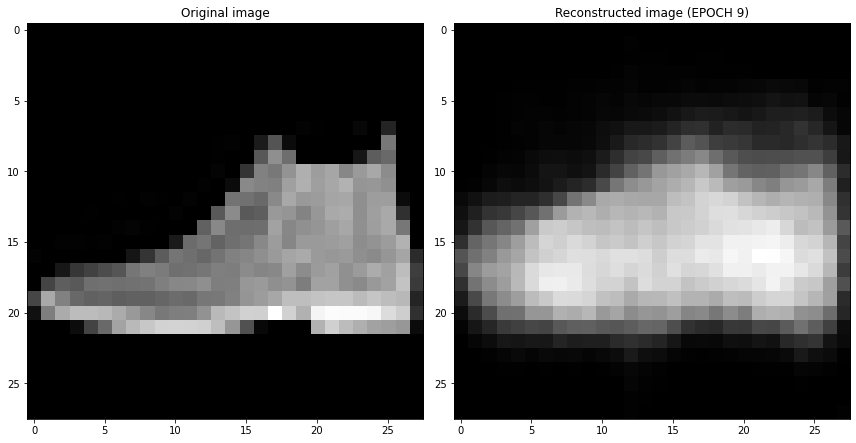

EPOCH 10/10
	 partial train loss (single batch): 0.032754
	 partial train loss (single batch): 0.031141
	 partial train loss (single batch): 0.032061
	 partial train loss (single batch): 0.031006
	 partial train loss (single batch): 0.033170
	 partial train loss (single batch): 0.035081
	 partial train loss (single batch): 0.033823
	 partial train loss (single batch): 0.032765
	 partial train loss (single batch): 0.033927
	 partial train loss (single batch): 0.032637
	 partial train loss (single batch): 0.033168
	 partial train loss (single batch): 0.032669
	 partial train loss (single batch): 0.031564
	 partial train loss (single batch): 0.031597
	 partial train loss (single batch): 0.031764
	 partial train loss (single batch): 0.032236
	 partial train loss (single batch): 0.033674
	 partial train loss (single batch): 0.032102
	 partial train loss (single batch): 0.032326
	 partial train loss (single batch): 0.032367
	 partial train loss (single batch): 0.031544
	 partial train loss (

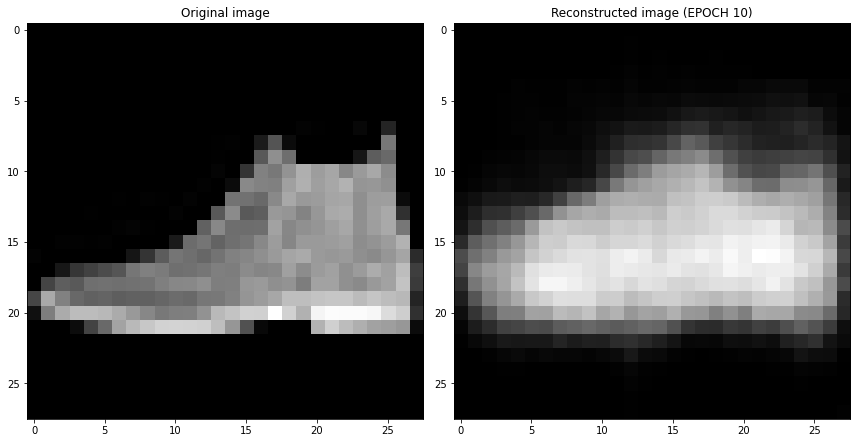

In [23]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 10  # this is the only line we change!
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)


### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 5e-4 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

In [24]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:15<00:00, 626.39it/s]


,Enc. Variable 0,Enc. Variable 1,label
0,-4.126853,-16.415049,9
1,1.149239,10.599757,2
2,-36.186043,8.173777,1
3,-37.846252,3.942347,1
4,-3.802211,0.012608,6
...,...,...,...
9995,13.778632,-16.934174,9
9996,-30.387487,-1.099942,1
9997,-10.146569,-1.097611,8
9998,-44.397514,5.536964,1


**How can we visualize data?** we like 2D-3D plots for intuition!

PCA and tSNE come into play.

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)
encoded_samples_reduced_PCA

array([[-13.8512543 ,  -6.0154351 ],
       [  2.82021691,  16.37551644],
       [ 26.78781644, -12.23896383],
       ...,
       [  1.37663269,   0.23824433],
       [ 30.52335668, -19.98546442],
       [-11.87770251,  -7.4222148 ]])

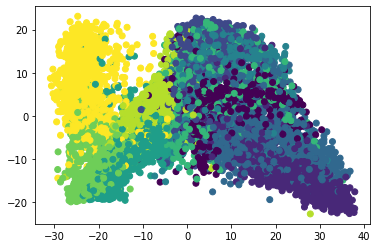

In [26]:
plt.scatter(encoded_samples_reduced_PCA[:,0], encoded_samples_reduced_PCA[:,1], c=encoded_samples.label.to_numpy())

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/home/irong/nn_deep_learning_2021/dl_env/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



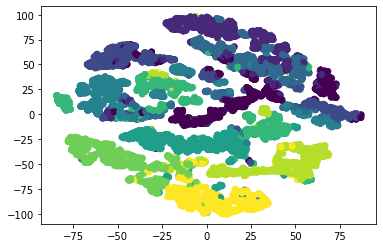

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)
plt.scatter(encoded_samples_reduced_TSNE[:,0], encoded_samples_reduced_TSNE[:,1], c=encoded_samples.label.to_numpy())

Given a point cloud:
*   **PCA** is like taking a snapshot from a different perspective/angle (linear only)
*   **tSNE** is like taking a snapshot from a different perspective/angle and at the same time stretching the space (non-linear)


**Autoencoders** can be used to solve a variety of different tasks!


*   Denoising images: add random noise to the training transform and want to predict the denoised image
*   Filling holes: add random holes in the image and predict the filled image
*   Image Generation: via Variational Autoencoders VAEs,...

